In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datasist.structdata import detect_outliers
from category_encoders.binary import BinaryEncoder
 
## other
#from imblearn.over_sampling import SMOTE

## sklearn -- preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, mutual_info_regression

## sklearn -- models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor

## skelarn -- metrics
from sklearn.metrics import f1_score, accuracy_score, r2_score, mean_squared_error

## ensemble models
from sklearn.ensemble import VotingRegressor,  AdaBoostRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

## `Dataset`

### `Data URL`
- https://www.kaggle.com/code/touba7/insurance-prediction-with-five-regressor-models/data

### `Read Dataset`

In [3]:
df = pd.read_csv("houses.csv", na_values=['Unknown', '', 'na', 'nan', 'NA', 'NAN', '-' ])

# Drop index column and description column 
df.drop(['Ad List', 'description'], axis=1, inplace=True)
df.head(3)

,Bedroom,Bathroom,Property Size,Nearby School,Nearby Mall,Category,Facilities,Building Name,Developer,Tenure Type,...,REN Number,Bus Stop,Mall,Park,School,Hospital,price,Highway,Nearby Railway Station,Railway Station
0,4.0,2.0,1000 sq.ft.,Sekolah Menengah Pendidikan Khas Cacat Penglih...,Setapak Central,"Apartment / Condominium, For sale",NaN,Kenwingston Platz,Kenwingston Group,Freehold,...,NaN,Bus Stop Starparc Point\nBus Stop Setapak Cent...,Setapak Central,"Park at Taman Tasik Danau Kota, Setapak, Kuala...",Sekolah Menengah Pendidikan Khas Cacat Penglih...,Columbia Asia Hospital,RM 340 000,NaN,NaN,NaN
1,3.0,2.0,980 sq.ft.,NaN,NaN,"Apartment / Condominium, For sale","Parking, Security, Swimming Pool, Playground, ...",Kenanga (Park View Court),NaN,Freehold,...,REN 15862,NaN,NaN,NaN,NaN,NaN,RM 250 000,NaN,NaN,NaN
2,3.0,2.0,1000 sq.ft.,NaN,NaN,"Apartment / Condominium, For sale","Playground, Minimart, Jogging Track, Barbeque ...",Sri Lavender Apartment,TLS Group,Freehold,...,NaN,NaN,NaN,NaN,NaN,NaN,RM 230 000,SILK Sg Ramal (T) Toll Plaza,NaN,NaN


In [4]:
df.shape

(4000, 30)

### `Replace spaces inside columns names with underscore`

In [5]:
# trim and replace space inside columns names with _
df.columns = df.columns.str.lower().str.strip().str.strip().str.replace(' ', '_')
df.rename(columns={'#_of_floors':'number_of_floors'}, inplace=True)
df.columns

Index(['bedroom', 'bathroom', 'property_size', 'nearby_school', 'nearby_mall',
       'category', 'facilities', 'building_name', 'developer', 'tenure_type',
       'address', 'completion_year', 'number_of_floors', 'total_units',
       'property_type', 'parking_lot', 'floor_range', 'land_title',
       'firm_type', 'firm_number', 'ren_number', 'bus_stop', 'mall', 'park',
       'school', 'hospital', 'price', 'highway', 'nearby_railway_station',
       'railway_station'],
      dtype='object')

### `Check the datatypes of the columns`

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bedroom                 3999 non-null   float64
 1   bathroom                3999 non-null   float64
 2   property_size           4000 non-null   object 
 3   nearby_school           687 non-null    object 
 4   nearby_mall             365 non-null    object 
 5   category                4000 non-null   object 
 6   facilities              3359 non-null   object 
 7   building_name           3913 non-null   object 
 8   developer               2269 non-null   object 
 9   tenure_type             4000 non-null   object 
 10  address                 3913 non-null   object 
 11  completion_year         1979 non-null   float64
 12  number_of_floors        2251 non-null   float64
 13  total_units             2098 non-null   float64
 14  property_type           4000 non-null   

In [7]:
df.describe()

,bedroom,bathroom,completion_year,number_of_floors,total_units,parking_lot
count,3999.000000,3999.000000,1979.000000,2251.000000,2098.000000,2781.000000
mean,2.917229,2.019755,2011.383527,21.650378,614.005243,1.506652
std,0.691838,0.607490,8.001577,25.792521,591.703145,0.700238
min,1.000000,1.000000,1985.000000,2.000000,1.000000,1.000000
25%,3.000000,2.000000,2006.000000,12.000000,290.000000,1.000000
50%,3.000000,2.000000,2014.000000,20.000000,462.000000,1.000000
75%,3.000000,2.000000,2017.000000,27.000000,753.500000,2.000000
max,10.000000,8.000000,2026.000000,504.000000,7810.000000,10.000000


In [8]:
df.describe(include=['O'])

,property_size,nearby_school,nearby_mall,category,facilities,building_name,developer,tenure_type,address,property_type,...,ren_number,bus_stop,mall,park,school,hospital,price,highway,nearby_railway_station,railway_station
count,4000,687,365,4000,3359,3913,2269,4000,3913,4000,...,2964,708,475,807,948,343,4000,141,363,485
unique,849,253,92,1,2201,1937,580,2,1828,8,...,962,336,132,357,429,79,562,31,93,142
top,700 sq.ft.,Vikas International School,Setapak Central,"Apartment / Condominium, For sale","Parking, Security, Lift, Swimming Pool, Playgr...",All Seasons Park,Ideal Property Group,Freehold,"Lebuhraya Thean Teik, Ayer Itam, Penang",Condominium,...,REN 22963,Bus Stop KL 1284 Wisma Buddist\nBus Stop KL 11...,Mid Valley Megamall,"Park at Taman Halimahton, Seputeh, Kuala Lumpu...",Vikas International School,Columbia Asia Hospital,RM 350 000,Loke Yew Toll Plaza,KTM Station Batu Caves (Komuter Seremban Line),KTM Station Batu Caves (Komuter Seremban Line)
freq,201,19,19,4000,142,25,68,2426,40,1714,...,86,26,26,26,26,26,81,17,23,35


## `Data Cleaning`

### `Check duplicates and drop them`

In [9]:
df.duplicated().sum()

210

In [10]:
df.drop_duplicates(inplace= True)
df.reset_index(inplace= True, drop= True)
df.duplicated().sum()

0

### `Check number of NA cells in each column`

In [11]:
# print the percentage of null cells in each column ordered desc 
df.isna().sum().sort_values(ascending=False) / df.shape[0]

highway                   0.964380
hospital                  0.913984
nearby_railway_station    0.909763
nearby_mall               0.908971
mall                      0.879947
railway_station           0.878364
nearby_school             0.826913
bus_stop                  0.820317
park                      0.794723
school                    0.758839
completion_year           0.501319
total_units               0.472032
number_of_floors          0.432982
developer                 0.431398
parking_lot               0.305805
floor_range               0.267810
ren_number                0.259894
firm_type                 0.183641
firm_number               0.183641
facilities                0.159367
address                   0.022427
building_name             0.022427
bathroom                  0.000264
bedroom                   0.000264
land_title                0.000000
property_type             0.000000
tenure_type               0.000000
price                     0.000000
category            

### `Drop columns that have nullable values more than 70% of its size`

In [12]:
# empty_cells_percentages = df.isna().sum().sort_values(ascending=False) / df.shape[0]
# columns = empty_cells_percentages[empty_cells_percentages > 0.7].index
# df.drop(columns, axis=1, inplace=True)
# df.shape

### `Convert Property-size to numerical by removing 'sq.ft'`

In [13]:
def fix_property_size(value:str):
    return value.replace('sq.ft.', '').strip()
df['property_size'] = df['property_size'].apply(fix_property_size).astype(float)
df['property_size'].describe()

count      3790.000000
mean       1038.399472
std        2064.470157
min           1.000000
25%         750.000000
50%         901.000000
75%        1116.000000
max      122774.000000
Name: property_size, dtype: float64

### `Drop column Category because it contains only one value`

In [14]:
df.drop(['category'], axis=1, inplace=True)

### `Remove the currency 'RM' (Malaysian Ringgit) from price column`

In [15]:
def fix_price(value:str):
    if isinstance(value, float):
        return value
    else:
        modified_value = value.replace(' ', '').replace('RM', '')
        return float(modified_value) 

df['price'] = df['price'].apply(fix_price) 
df['price'].describe()

count    3.790000e+03
mean     4.228414e+05
std      3.296569e+05
min      3.800000e+04
25%      2.500000e+05
50%      3.500000e+05
75%      4.900000e+05
max      6.016000e+06
Name: price, dtype: float64

### `Convert the fload fields which are discrete to int type`

In [16]:
df['bedroom'] = df['bedroom'].astype('Int64')
df['bathroom'] = df['bathroom'].astype('Int64')
df['completion_year'] = df['completion_year'].astype('Int64')
df['number_of_floors'] = df['number_of_floors'].astype('Int64')
df['total_units'] = df['total_units'].astype('Int64')
df['parking_lot'] = df['parking_lot'].astype('Int64')

## `Feature Engineering`

### `Create boolean column to indicate the existence of nearby services`

In [17]:
df['nearby_highway'] = df['highway'].isna() == False
df['nearby_hospital'] = df['hospital'].isna() == False
df['nearby_railway_station'] = df['nearby_railway_station'].isna() == False
df['nearby_mall'] = df['nearby_mall'].isna() == False
df['nearby_mall2'] = df['mall'].isna() == False
df['nearby_railway_station'] = df['railway_station'].isna() == False
df['nearby_school'] = df['nearby_school'].isna() == False
df['nearby_bus_stop'] = df['bus_stop'].isna() == False
df['nearby_park'] = df['park'].isna() == False
df['nearby_school'] = df['school'].isna() == False

df.drop(columns=['highway', 'hospital', 'mall', 'railway_station', 'bus_stop', 'park', 'school'], axis=1, inplace=True)




### `Column Facilities contains multiple categories, extract each category into separate column and drop 'Facilities'`

In [18]:
def split_facilities_into_separate_columns(df):
    for index in df.index:
        facilities = df.loc[index, 'facilities']
        
        if type(facilities) == str:
    
            parts = facilities.split(',')

            # loop on each facility 
            for part in parts:
                part = part.strip()
            
                col_name = 'facility_' + part
                if col_name not in df.columns:
                    # initialize new column with value False
                    df.loc[:, col_name] = False
                    
                # indicate that the current row has this facility
                df.loc[index, col_name] = True
    return df

df = split_facilities_into_separate_columns(df)
df.describe(include='bool')

,nearby_school,nearby_mall,nearby_railway_station,nearby_highway,nearby_hospital,nearby_mall2,nearby_bus_stop,nearby_park,facility_Parking,facility_Security,...,facility_Jogging Track,facility_Minimart,facility_Lift,facility_Gymnasium,facility_Multipurpose hall,facility_Sauna,facility_Tennis Court,facility_Club house,facility_Squash Court,facility_10
count,3790,3790,3790,3790,3790,3790,3790,3790,3790,3790,...,3790,3790,3790,3790,3790,3790,3790,3790,3790,3790
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,False,False,False,False
freq,2876,3445,3329,3655,3464,3335,3109,3012,2877,2862,...,2445,2278,1987,1920,2551,2782,3142,3193,3223,3789


In [19]:
df.drop(['facility_10'], axis=1, inplace=True)

In [20]:
df.shape

(3790, 41)

In [21]:
df.drop(['facilities'], axis=1, inplace=True)

### `Extract from property-agent-number field (REN-Number) the type (REN - PEA - E - REA - PV - V) and the number`

In [22]:
def split_agent_number(value):
    if isinstance(value, float):
        return pd.Series([np.nan, float(value)])
    else:
        parts = value.split(' ')
        return pd.Series([parts[0], float(parts[1])]) 
 
df[['ren_type', 'ren_number']] =  df['ren_number'].apply(split_agent_number) 
df['ren_number'] = df['ren_number'].astype('Int64')


In [23]:
df[['ren_type', 'ren_number']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3790 entries, 0 to 3789
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ren_type    2805 non-null   object
 1   ren_number  2805 non-null   Int64 
dtypes: Int64(1), object(1)
memory usage: 63.0+ KB


In [24]:
df['ren_type'].value_counts()

ren_type
REN    2574
PEA     130
E        71
REA      22
PV        5
V         3
Name: count, dtype: int64

### `Extract City, State from Address`

In [25]:
import re

result = df['address'].apply(lambda x :  np.array(re.findall(r'\b\w+\b', x)) if isinstance(x, str) else np.array(1)  )
unique_words = {}

def increment_unique_words(x):
    if x in unique_words:
        unique_words[x]+=1
    else:
        unique_words[x] = 1 
 

#[unique_words.add(x) for x in result[0]]
result.apply(lambda lst : [ increment_unique_words(x) for x in lst] if isinstance(lst, np.ndarray) else 'test'  )



sorted_unique_words = sorted(unique_words.items(), key=lambda x:x[1], reverse=True)
print(sorted_unique_words)
 


[('Jalan', 2559), ('Selangor', 1269), ('Penang', 993), ('Taman', 716), ('Kuala', 686), ('Lumpur', 683), ('Johor', 632), ('Off', 515), ('1', 422), ('Bandar', 375), ('Bukit', 348), ('Persiaran', 328), ('2', 321), ('Cheras', 267), ('Sungai', 249), ('Alam', 242), ('Bahru', 234), ('Jaya', 232), ('Jelutong', 220), ('3', 218), ('Itam', 213), ('Ayer', 196), ('Kota', 188), ('Batu', 181), ('Shah', 179), ('Seri', 179), ('Bayan', 175), ('Indah', 172), ('Sabah', 170), ('Puchong', 167), ('Kajang', 157), ('Ampang', 149), ('No', 148), ('Lebuhraya', 144), ('Kuching', 138), ('Baru', 137), ('Sentul', 137), ('Lorong', 131), ('Putrajaya', 131), ('Kinabalu', 129), ('4', 128), ('Perdana', 127), ('Klang', 124), ('Lepas', 123), ('Sarawak', 122), ('Utama', 120), ('Sri', 115), ('Seksyen', 113), ('9', 110), ('Ara', 107), ('Tun', 104), ('Petaling', 104), ('Kembangan', 101), ('Dato', 101), ('Thean', 101), ('Teik', 101), ('5', 99), ('Gelugor', 98), ('10', 98), ('Desa', 94), ('Melaka', 91), ('7', 90), ('Setapak', 89)

In [26]:
# def split_address_into_separate_columns(df):
#     for index in df.index:
#         address = df.loc[index, 'address']
        
#         if type(address) == str:
    
#             parts = np.array(re.findall(r'\b\w+\b', address))

#             # loop on each address 
#             for part in parts:
#                 #print(part)
            
#                 if part not in df.columns:
#                     # initialize new column with value Zero
#                     df.loc[:, part] = 0
                    
#                 # indicate that the current row has this word
#                 df.loc[index, part] += 1 
#     return df

# #split_address_into_separate_columns(df)
# df = split_address_into_separate_columns(df)


In [27]:
df.describe(include='Int64')

,bedroom,bathroom,completion_year,number_of_floors,total_units,parking_lot,ren_number
count,3789.0,3789.0,1890.0,2149.0,2001.0,2631.0,2805.0
mean,2.916601,2.019266,2011.408995,21.580735,612.621689,1.508552,29433.958289
std,0.684272,0.601738,8.012591,24.749332,587.307579,0.689839,19419.997891
min,1.0,1.0,1985.0,2.0,1.0,1.0,0.0
25%,3.0,2.0,2006.0,12.0,290.0,1.0,13381.0
50%,3.0,2.0,2014.0,20.0,462.0,1.0,27348.0
75%,3.0,2.0,2017.0,28.0,754.0,2.0,44186.0
max,10.0,8.0,2026.0,504.0,7810.0,10.0,99999.0


In [28]:
states = ['Johor', 'Kedah', 'Kelantan', 'Malacca', 'Negeri Sembilan', 'Pahang', 'Penang', 
          'Perak', 'Perlis', 'Sabah', 'Sarawak', 'Selangor', 'Terengganu', 'Kuala Lumpur', 'Labuan', 'Putrajaya']

cities = ['Kajang', 'Seberang Perai', 'Subang Jaya', 'Klang', 'Johor Bahru', 'Shah Alam', 'George Town', 'Petaling Jaya',
           'Selayang', 'Ipoh', 'Seremban', 'Iskandar Puteri', 'Kuantan', 'Sungai Petani', 'Ampang Jaya', 'Kota Kinabalu',
            'Melaka City', 'Sandakan', 'Alor Setar', 'Tawau', 'Batu Pahat', 'Kota Bharu', 'Kuala Terengganu', 'Kuching',
             'Sepang', 'Kulim', 'Muar', 'Pasir Gudang', 'Kuala Langat', 'Kulai', 'Kangar',
           'Kuala Selangor', 'Padawan', 'Miri', 'Manjung', 'Hulu Selangor', 'Taiping', 'Bintulu', 'Kubang Pasu', 'Kluang',
             'Pasir Mas', 'Lahad Datu', 'Alor Gajah', 'Kemaman', 'Hang Tuah Jaya', 'Tumpat', 'Pontian', 'Teluk Intan', 'Sibu', 
             'Temerloh', 'Semporna', 'Kerian', 'Tangkak', 'Penampang', 'Kota Samarahan', 'Ketereh', 'Dungun', 'Bachok',
               'Besut', 'Segamat', 'Keningau', 'Tanah Merah', 'Papar', 'Ampang', 'Setapak', 'Bayan Baru', 'Puchong', 'Wangsa Maju', 
               'Simpang Ampat', 'Cheras', 'Semenyih', 'Iskandar Puteri', 'Bangi', 'Ayer Keroh', 'Setia Alam', 'Sentul', 'Cyberjaya',
               'Seri Kembangan', 'Gelugor', 'Skudai', 'Ayer Itam', ' Tanjung Bungah', 'Rawang', 'Gelang Patah', 'Nusajaya', 'Damansara Perdana']
 



In [29]:
import re

def extract_address_fields(value):
    if isinstance(value, str):   

        ## extract postal code, it is a number consists of 5 digits
        #postal_code = np.nan
        #postal_codes = re.findall(r'\d{5}', value)        
        #if len(postal_codes) > 0:
        #    postal_code = postal_codes[0]

        ## extract street names and numbers, they exist on the format 
        #postal_codes = re.findall(r'[^,]+\d+/\d+|[^,]+\d+', value)
        #if len(postal_codes) > 0:
        #    print(postal_codes)

        ## extract city, state they are the last two parts in the string
        address_parts = [x.strip() for x in value.split(',')]
        #print(list(set(cities) & set(address_parts)))
        
        #result = address_parts[-2:]
        result = list()

        found_states = list(set(states) & set(address_parts))
        if len(found_states) > 0:
            result = np.append(result, found_states[0])

        found_cities = list(set(cities) & set(address_parts))
        if len(found_cities) > 0:
            result = np.append(result, found_cities[0])
 
        #result = np.append(result, postal_code)
        return pd.Series(result)
    else: 
        return pd.Series([np.nan, np.nan])
   
df[['state', 'city']] = df['address'].apply(extract_address_fields)

In [30]:
df[['city', 'state']].describe()

,city,state
count,2289,3671
unique,46,17
top,Johor Bahru,Selangor
freq,231,1234


In [31]:
df.drop(['address'], axis=1, inplace=True)

## `Visualization`

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3790 entries, 0 to 3789
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bedroom                     3789 non-null   Int64  
 1   bathroom                    3789 non-null   Int64  
 2   property_size               3790 non-null   float64
 3   nearby_school               3790 non-null   bool   
 4   nearby_mall                 3790 non-null   bool   
 5   building_name               3705 non-null   object 
 6   developer                   2155 non-null   object 
 7   tenure_type                 3790 non-null   object 
 8   completion_year             1890 non-null   Int64  
 9   number_of_floors            2149 non-null   Int64  
 10  total_units                 2001 non-null   Int64  
 11  property_type               3790 non-null   object 
 12  parking_lot                 2631 non-null   Int64  
 13  floor_range                 2775 

 
boxplot of charges


### `Draw histogram for numerical fields`

In [33]:
#sns.set_theme(style="darkgrid")

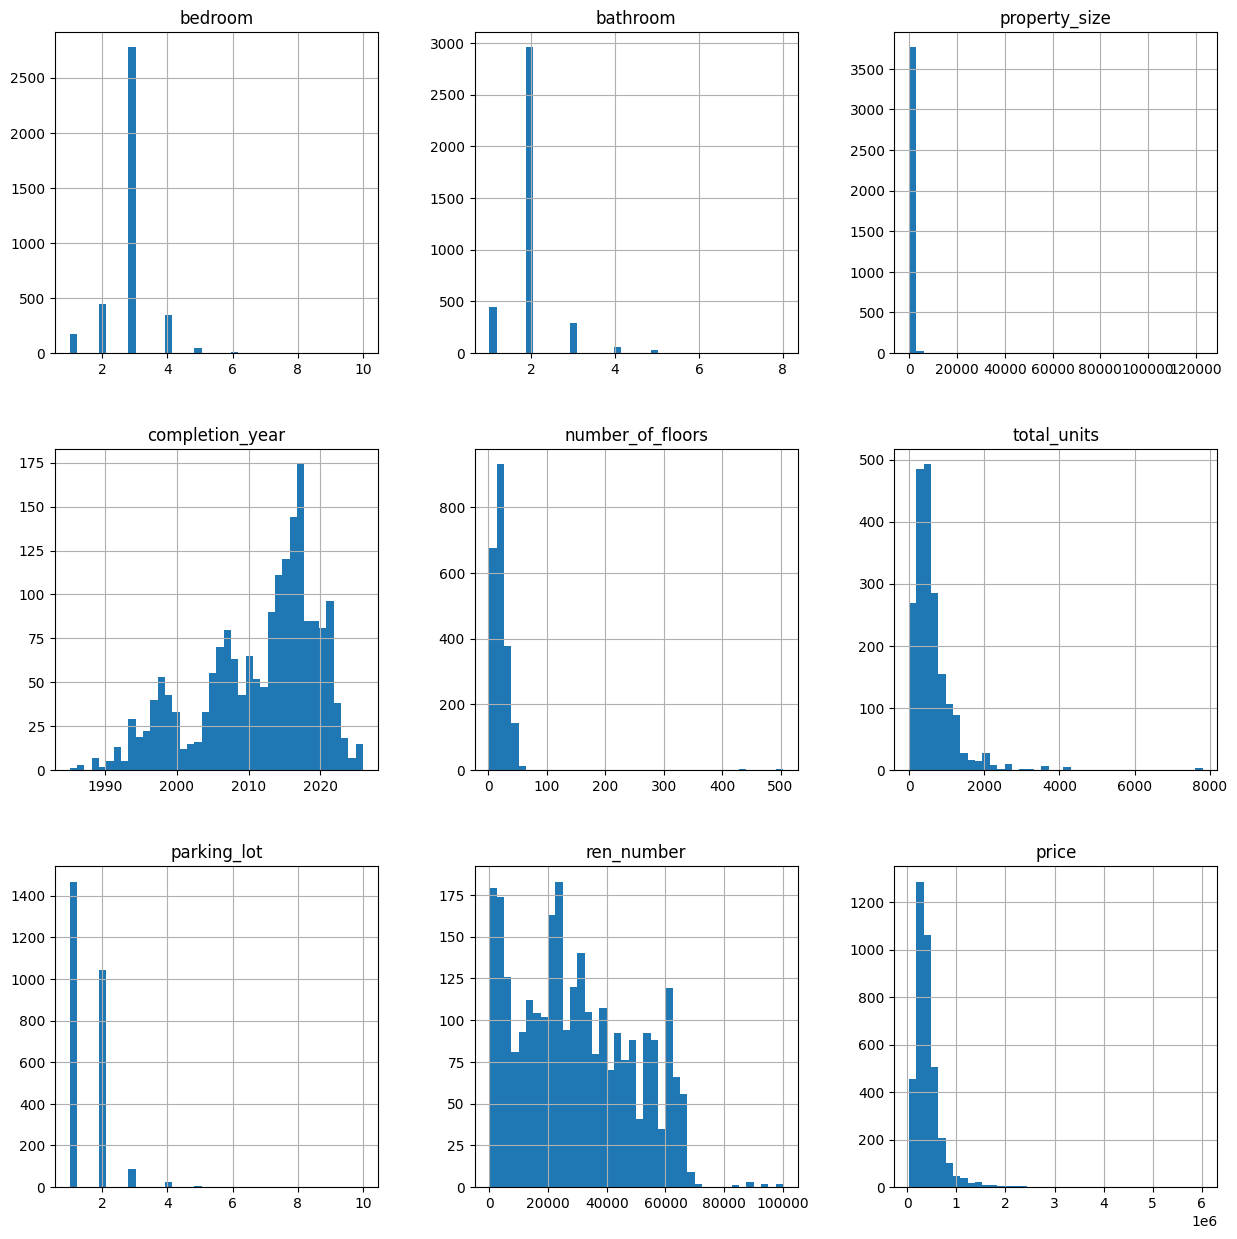

In [34]:
df.hist(bins=40, figsize=(15,15))
plt.show()


### `Detect Outliers of the field 'property_size' and replace them with the Meadian`

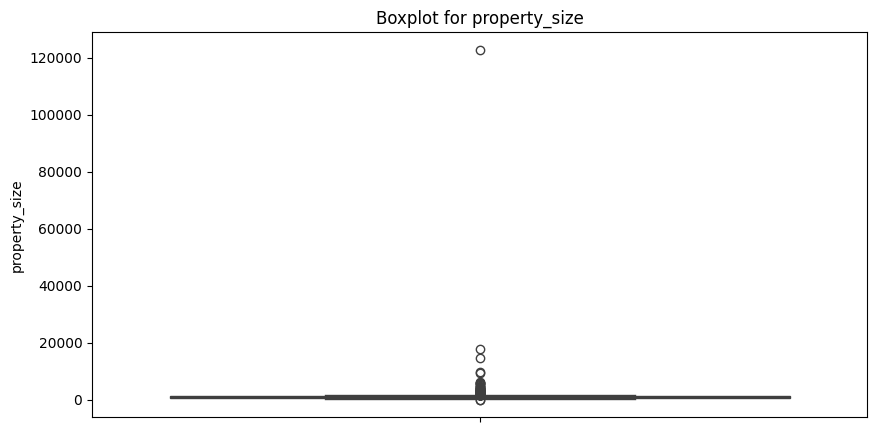

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='property_size')
plt.title('Boxplot for property_size')
plt.show()

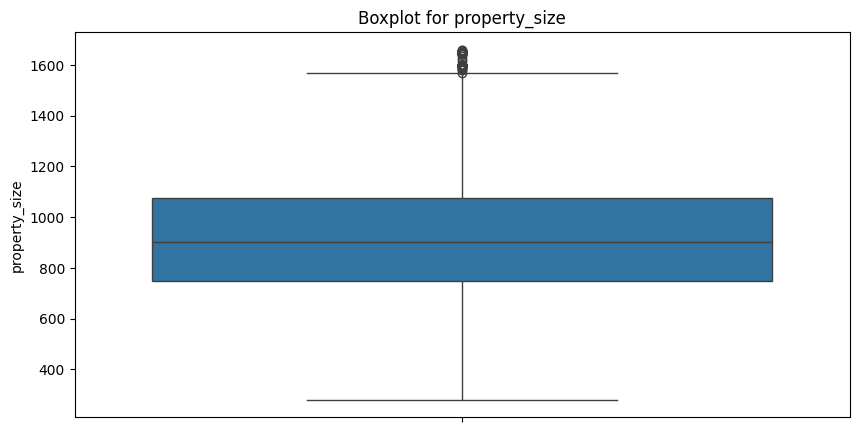

In [36]:
cols = np.array(['property_size'])
 
for col in cols: 
    outliers_indices = detect_outliers(df, 0, [col]) 
     
    col_median = df[col].median() 
    df.loc[outliers_indices, col] = col_median

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='property_size')
plt.title('Boxplot for property_size')
plt.show()

### `Draw diagram for the feature to determine the most common ones`

In [37]:
def reshape_and_expand_array(arr, no_of_rows):
    # if the array can not be divided by param 'first_dimention' then reshape will raise error
    # expand the array with nan values to be able to reshape it
    if arr.shape[0] % no_of_rows > 0:
        no_of_needed_cells = no_of_rows - arr.shape[0] % no_of_rows

        empty_array = np.empty((no_of_needed_cells),dtype=np.string_)
        empty_array[:] = ''
         
        arr = np.append(arr, empty_array)
 
    return arr.reshape((no_of_rows, arr.shape[0] // no_of_rows))

In [38]:
def init_sub_plots(title, column_names_array, width, height):
    no_rows = len(column_names_array)
    no_columns = 0 if len(column_names_array) == 0 else  len(column_names_array[0])
 
    fig, axes = plt.subplots(no_rows, no_columns, figsize=(width, height), sharey=True)
    fig.suptitle(title)
    return (fig, axes)

In [39]:
def draw_countplots_for_columns(title, df, column_names_array, no_of_rows):
    column_names_array = reshape_and_expand_array(column_names_array, no_of_rows) 
     
    (fig, axes) = init_sub_plots(title, column_names_array, 15, 25) 
    
    for i in range(len(column_names_array)):
        for j in range(len(column_names_array[i])):
            if  isinstance(column_names_array[i,j], str) and column_names_array[i,j]!='': 
                
                sns.countplot(ax=axes[i,j], data=df, x=column_names_array[i,j])
                axes[i,j].set_title(column_names_array[i,j])

In [40]:
bool_columns = df.select_dtypes(include='bool').columns
facility_columns = [x  for x in bool_columns if x.startswith('facility_') ] 
 
# draw_countplots_for_columns('Diagram for Common features', df, np.array( facility_columns ), 5)

In [41]:
facility_columns_df = pd.DataFrame(df[facility_columns].sum(), columns=['count'])
facility_columns_df.reset_index(inplace=True)
facility_columns_df.columns = ['facility', 'count']
facility_columns_df


NameError: name 'facility_columns' is not defined

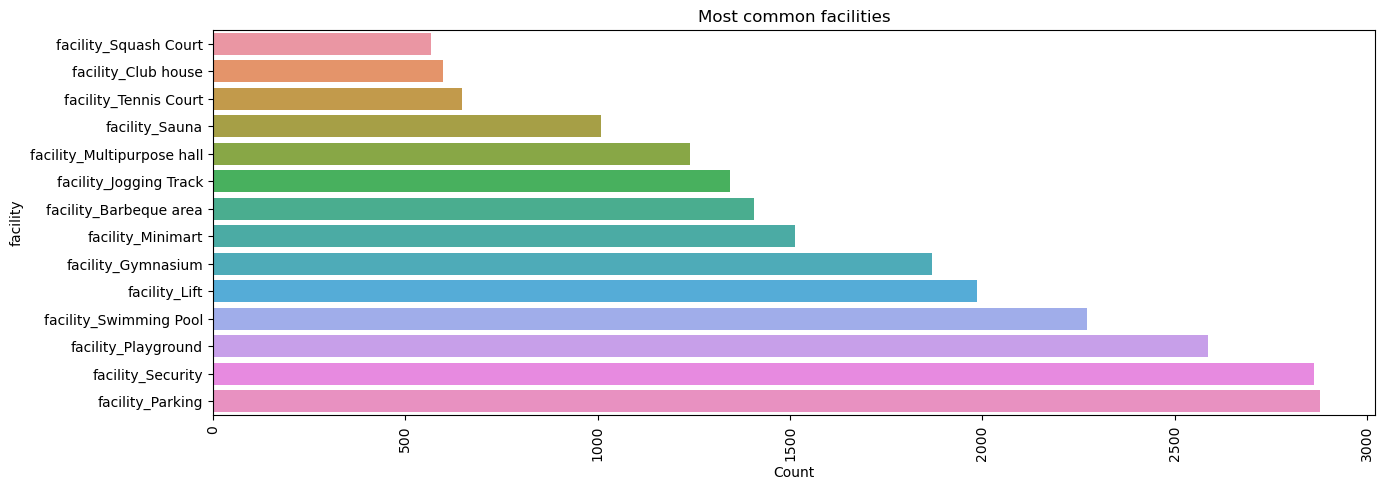

In [ ]:
 
plt.figure(figsize=(15,5))
sns.barplot(data=facility_columns_df.sort_values(by='count'), y = 'facility', x='count' )
plt.title('Most common facilities')
plt.xticks(rotation=90)
plt.ylabel('facility')
plt.xlabel('Count')
plt.show()

#### We can notice that most common features are:
- Parking
- Security
- Playground
- Swimming pool


### `Draw diagram to show how the features affect the price`

In [ ]:
def draw_histplots_for_price_with_columns(title, df, column_names_array, no_of_rows):
    column_names_array = reshape_and_expand_array(column_names_array, no_of_rows) 
 
    (fig, axes) = init_sub_plots(title, column_names_array, 15, 30) 
    
    for i in range(len(column_names_array)):
        for j in range(len(column_names_array[i])):
            if  isinstance(column_names_array[i,j] , str) and column_names_array[i,j] != '': 
                sns.histplot(ax=axes[i,j], data=df, x='price', hue=column_names_array[i,j], palette={0:'Red', 1:'Blue'})
                axes[i,j].set_title(column_names_array[i,j])

In [ ]:
df[df['price'] > 2000000].shape

(27, 44)

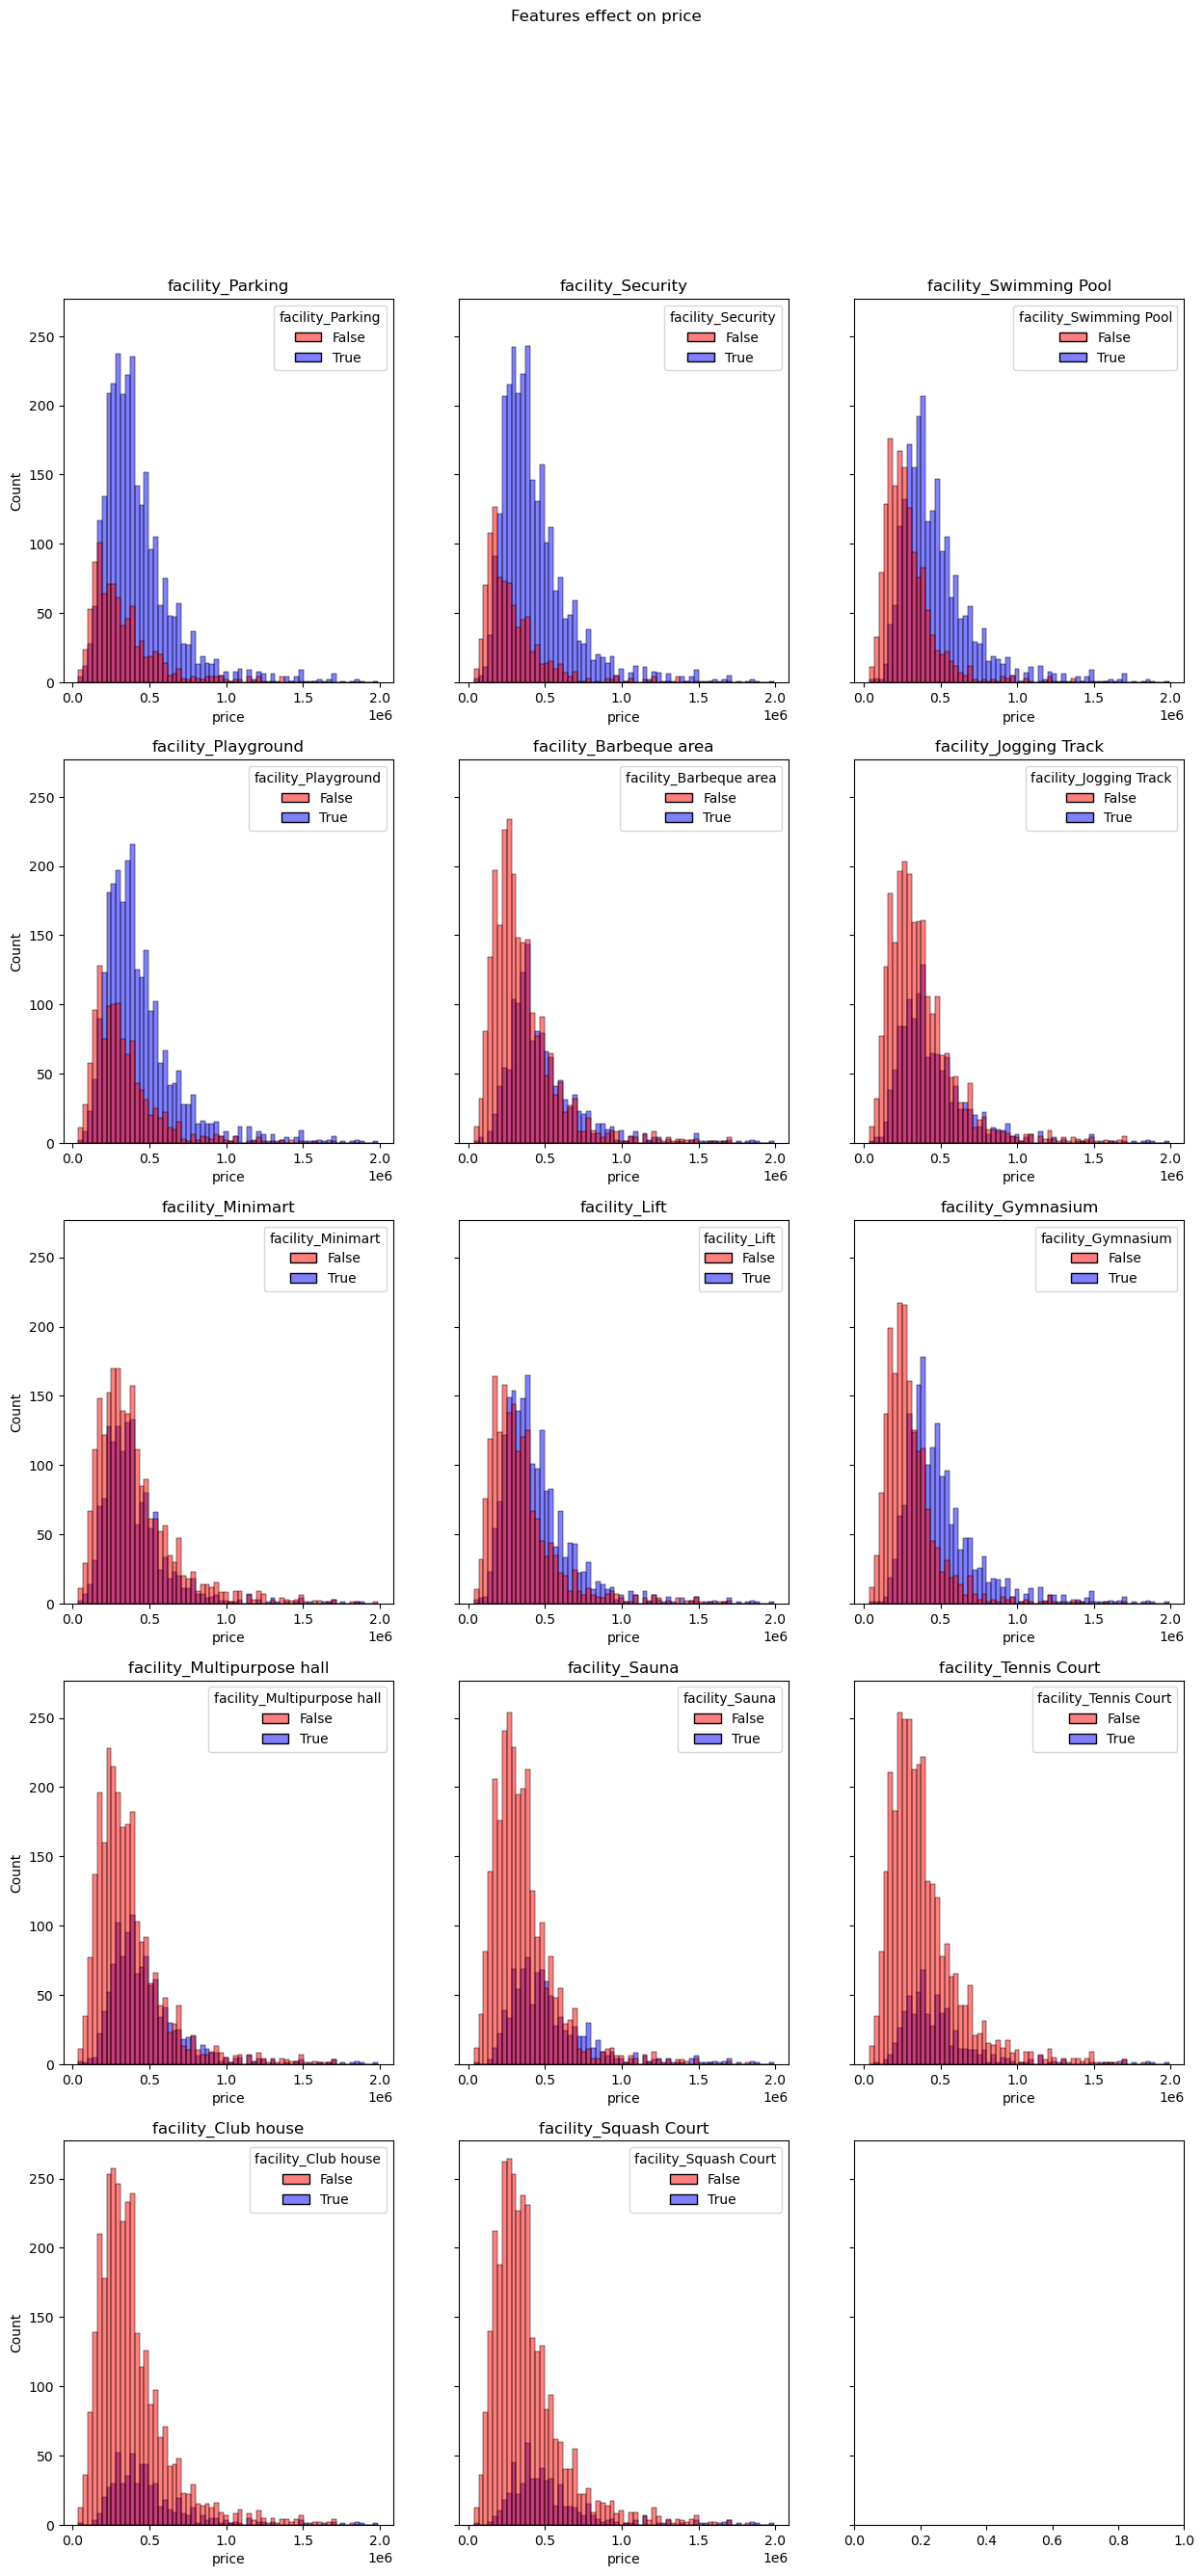

In [ ]:
# number of records whose price more than 2000000 is 28
# we will exclude these record to be able to compare the price with other columns easily
df_price_filtered = df[df['price'] <= 2000000] 
bool_columns = df.select_dtypes(include='bool').columns 
facility_columns = [x  for x in bool_columns if x.startswith('facility_') ] 
draw_histplots_for_price_with_columns('Features effect on price', df_price_filtered, np.array(facility_columns), 5)

#### We can notice that price increases when the following features are exist:
- Parking
- Security
- Swimming pool
- Playground
- Gymnasium
- Lift

### `Draw diagram to show total sales for each completion_year divided by 'tenure_type'`

In [ ]:
df_grouped = pd.DataFrame( df.groupby(by=['completion_year', 'tenure_type'])['price'].aggregate(['sum','count']) )
df_grouped.reset_index(drop=False, inplace=True ) 
df_grouped.sort_values(by='sum', ascending=False)

,completion_year,tenure_type,sum,count
58,2017,Freehold,74834887.0,122
60,2018,Freehold,49567287.0,75
56,2016,Freehold,47157388.0,84
54,2015,Freehold,46463998.0,80
66,2021,Freehold,42045500.0,60
...,...,...,...,...
75,2025,Leasehold,350000.0,1
7,1991,Leasehold,320000.0,1
4,1990,Freehold,230000.0,1
11,1993,Leasehold,230000.0,1


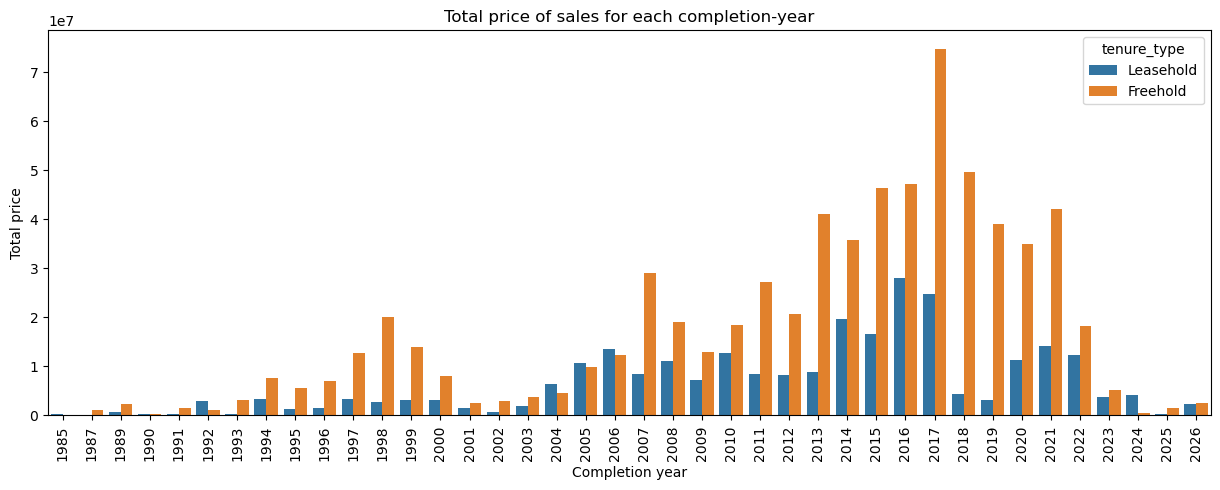

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_grouped, x = 'completion_year', y='sum', hue='tenure_type')
plt.title('Total price of sales for each completion-year')
plt.xticks(rotation=90)
plt.ylabel('Total price')
plt.xlabel('Completion year')
plt.show()

#### We can notice the greatest total price of sales was in 2017

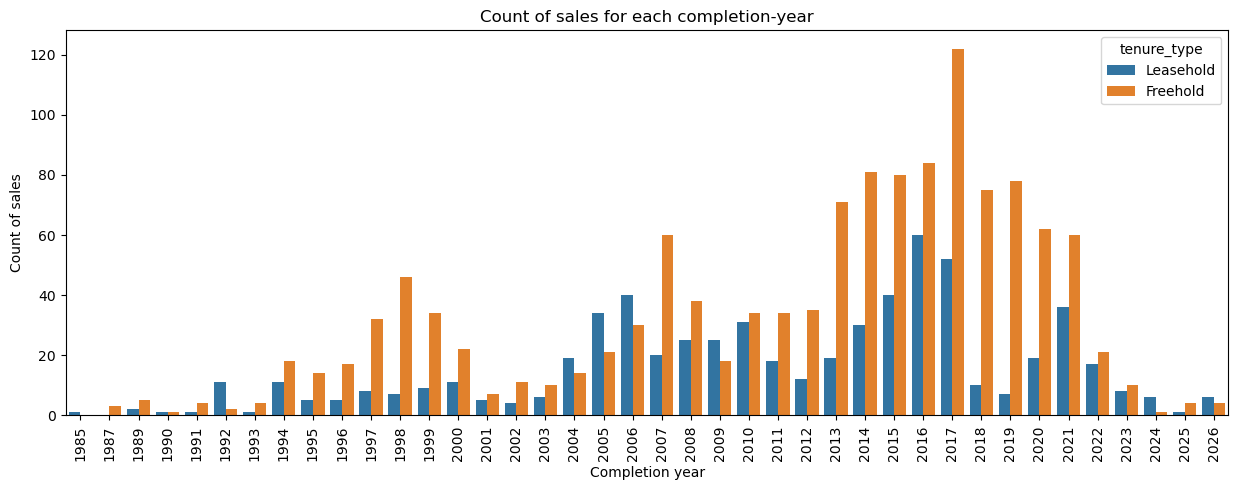

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_grouped, x = 'completion_year', y='count', hue='tenure_type')
plt.title('Count of sales for each completion-year')
plt.xticks(rotation=90)
plt.ylabel('Count of sales')
plt.xlabel('Completion year')
plt.show()

#### We can notice the greatest count of sales was in 2017

### `Draw histogram to show counts of sales for each property_type and tenure_type`

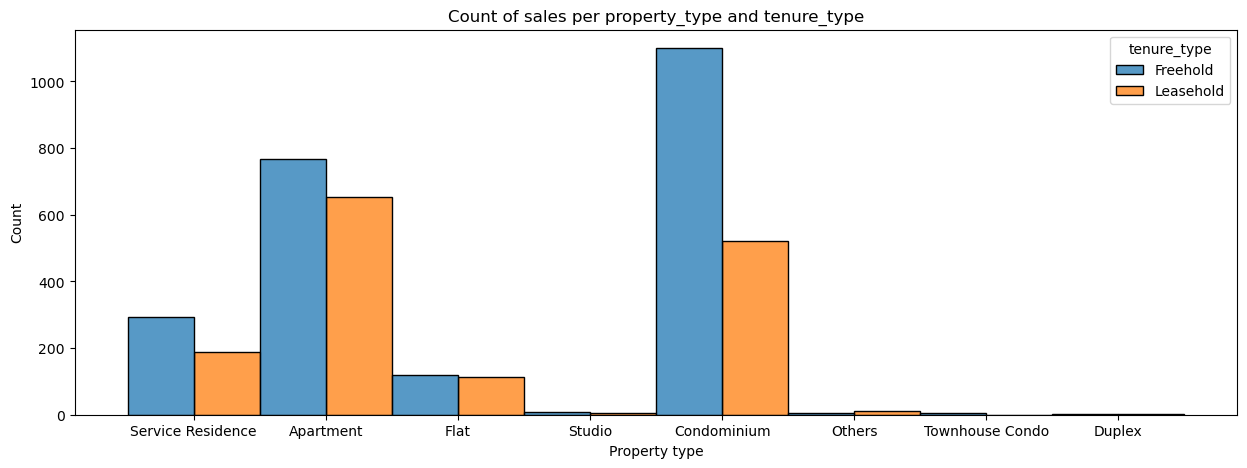

In [ ]:
plt.figure(figsize=(15,5))  
sns.histplot(data=df, x='property_type', hue='tenure_type', bins=30, multiple='dodge')
plt.title('Count of sales per property_type and tenure_type') 
plt.xlabel('Property type')
plt.show()

#### We can notice the following:
- The greatest count of sales of type Leasehold is for the Apartments
- The greatest count of sales of type Freehold is for the Condominium 

### `Print Pivot table to dispaly the number and total-amount of records for each completion_year and state`

In [ ]:
df_grouped = pd.DataFrame( df.groupby(by=['completion_year','state'])['price'].aggregate(['sum','count']) )

df_grouped.reset_index(drop=False, inplace=True )

In [ ]:
print('The sum of prices for each completion_year and each state')
pivot_data = pd.pivot(data=df_grouped, index='state', columns='completion_year', values=['sum','count'])
pivot_data['sum']

The sum of prices for each completion_year and each state


completion_year,1985,1987,1989,1990,1991,1992,1993,1994,1995,1996,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
state,,,,,,,,,,,,,,,,,,,,,
Ayer Keroh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,320000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Johor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5941888.0,8490090.0,6677000.0,399000.0,3228250.0,NaN,NaN,NaN,597000.0,1310000.0
Kedah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540000.0
Kuala Lumpur,NaN,NaN,680000.0,NaN,NaN,NaN,1822000.0,3290000.0,2165000.0,3605000.0,...,19037400.0,5030197.0,11797900.0,10546000.0,13168088.0,3130000.0,6023000.0,4026000.0,835000.0,1468000.0
Melaka City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,438000.0,NaN,NaN,NaN,NaN,NaN
Negeri Sembilan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,275000.0,NaN,NaN,NaN,NaN
Pahang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,400000.0,830000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Penang,198000.0,NaN,2215000.0,NaN,NaN,3939000.0,1530000.0,7642000.0,4710000.0,3750000.0,...,52938000.0,26805000.0,11850000.0,18581000.0,32318500.0,17663000.0,650000.0,NaN,NaN,NaN
Perak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,360000.0,NaN,NaN,178000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('The number of sold units for each completion_year and each state')
pivot_data['count']

The number of sold units for each completion_year and each state


completion_year,1985,1987,1989,1990,1991,1992,1993,1994,1995,1996,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
state,,,,,,,,,,,,,,,,,,,,,
Ayer Keroh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Johor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,17.0,19.0,1.0,9.0,NaN,NaN,NaN,2.0,4.0
Kedah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Kuala Lumpur,NaN,NaN,2.0,NaN,NaN,NaN,3.0,8.0,7.0,10.0,...,35.0,7.0,20.0,17.0,28.0,3.0,12.0,6.0,2.0,4.0
Melaka City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Negeri Sembilan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Pahang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Penang,1.0,NaN,5.0,NaN,NaN,13.0,2.0,21.0,12.0,8.0,...,72.0,33.0,12.0,29.0,41.0,16.0,1.0,NaN,NaN,NaN
Perak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### `Heatmap to dispaly the the number and total-price of sold-units for each completion_year and each state`

Text(0.5, 1.0, 'Total price of sales')

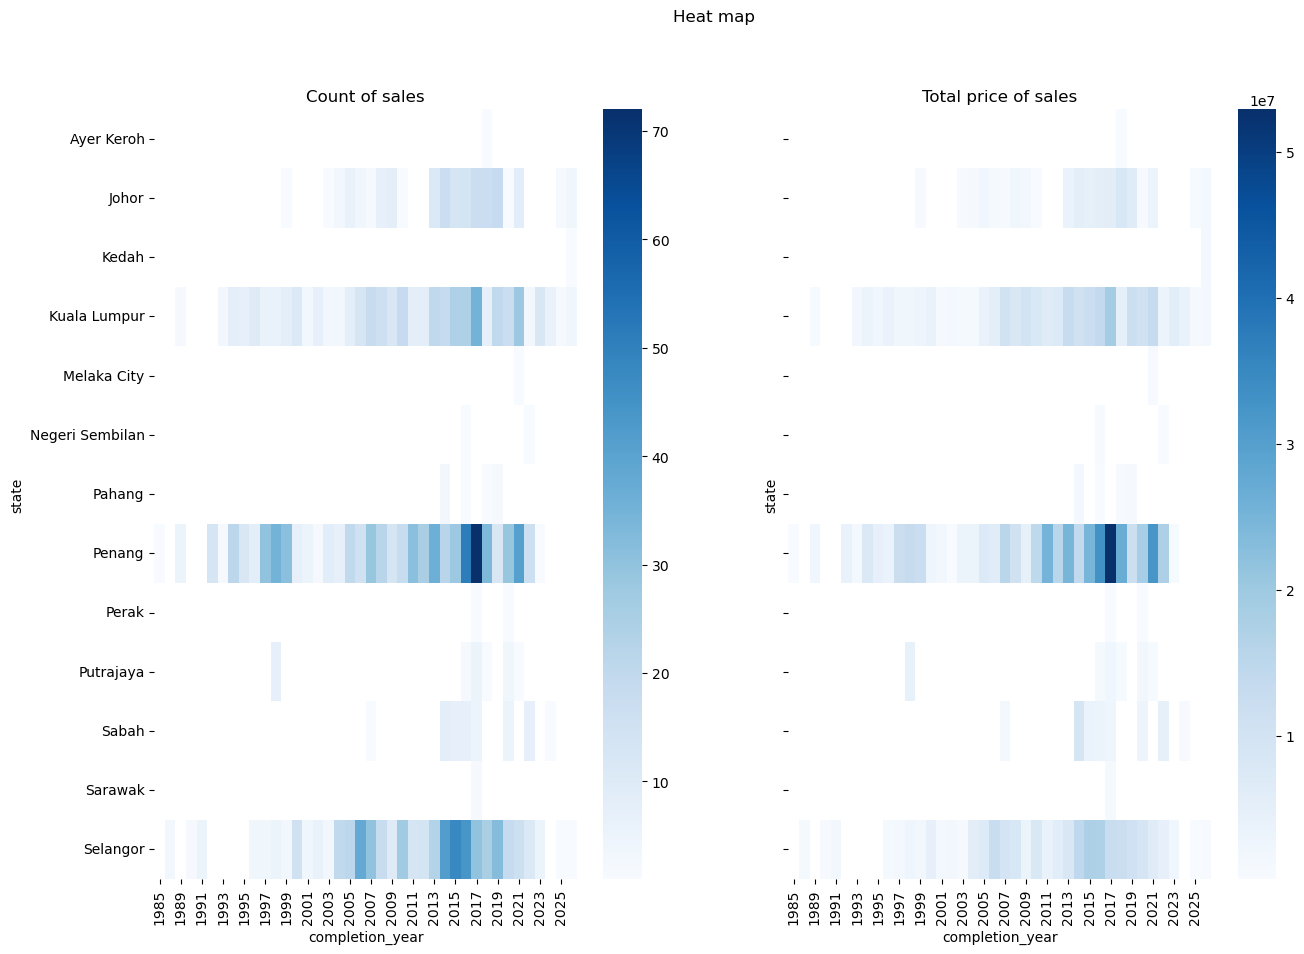

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
fig.suptitle('Heat map ')

sns.heatmap(ax=axes[0], data=pivot_data['count'], cmap="Blues")
axes[0].set_title('Count of sales')

sns.heatmap(ax=axes[1], data=pivot_data['sum'], cmap="Blues")
axes[1].set_title('Total price of sales')

#### We can notice that the following states have the greatest count of sales:
- Penang
- Selangor
- Kuala Lampur
- Johot 

### `Draw diagram to show the relation between price and property_size`

In [ ]:
count_empty_bedroom = df['bedroom'].isna().sum()
print(f'Count of null bedrooms = {count_empty_bedroom}')

Count of null bedrooms = 1


C:\Users\eahme\AppData\Local\Temp\ipykernel_18860\1018255725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['bedroom'] = df_filtered['bedroom'].astype(float)


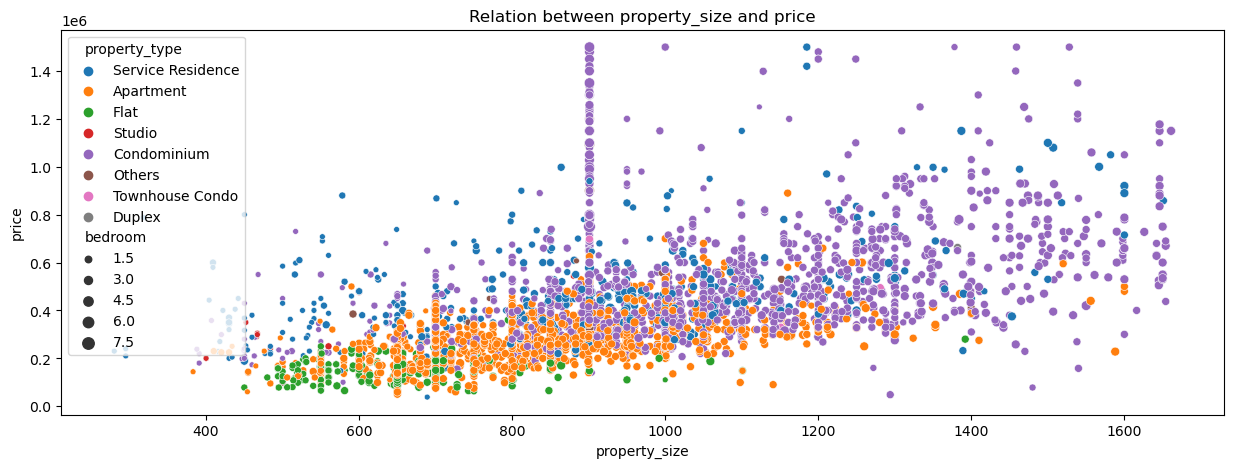

In [ ]:
df_filtered = df[(df['bedroom'].isna() == False) & (df['price'] <= 1500000)]
df_filtered['bedroom'] = df_filtered['bedroom'].astype(float) 

plt.figure(figsize=(15,5))
sns.scatterplot(data=df_filtered, y='price', x='property_size', hue='property_type', size='bedroom')
plt.title('Relation between property_size and price')
plt.show()

#### We can notice that the following (for prices less than 1500000):
- The average price of 'Service Residence' is greater than price of 'Apartment'
- The average price of 'Apartment' is greater than price of 'Flat'
- The price slightly increases proportionally with the property_size
- The number of bedrooms increases proportionally with the property_size 

### `Check the distribution of Price column`

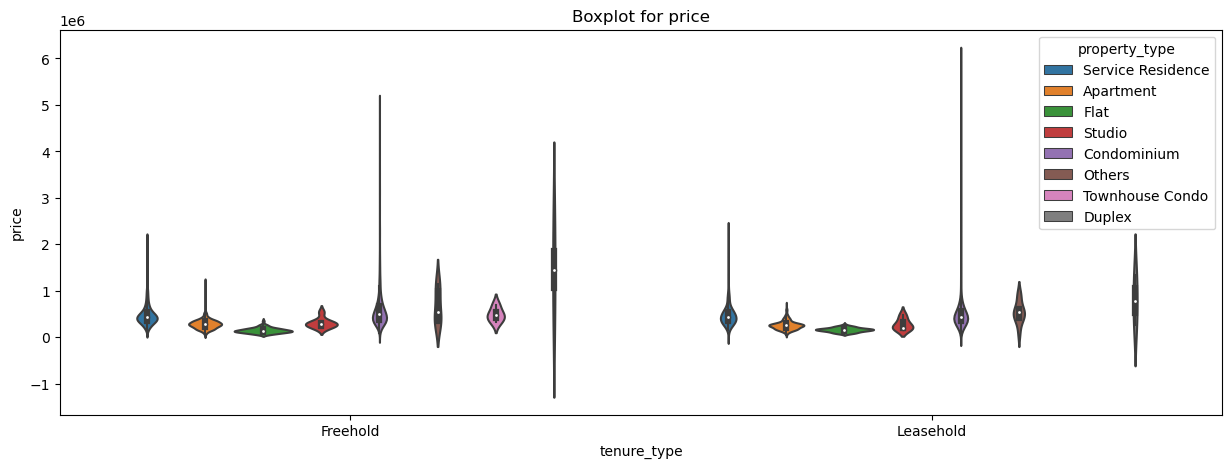

In [ ]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df, y='price', x='tenure_type', hue='property_type')
plt.title('Boxplot for price')
plt.show()

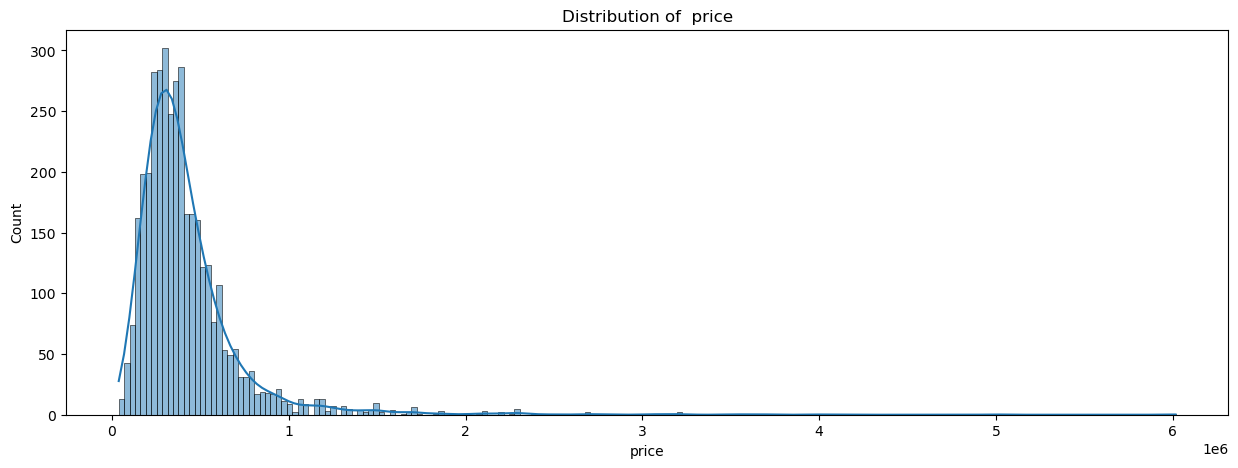

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='price', kde=True)
plt.title('Distribution of  price')
plt.show()

### `Check the distribution of log(Price) column`

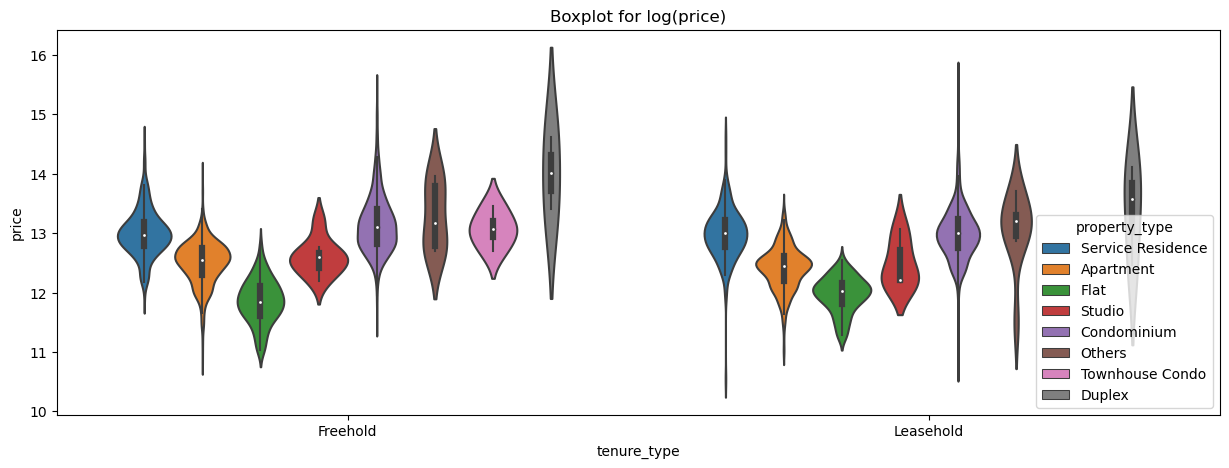

In [ ]:
# take log of the price 
df['price'] = np.log(df['price'])

plt.figure(figsize=(15,5))
sns.violinplot(data=df, y='price', x='tenure_type', hue='property_type')
plt.title('Boxplot for log(price)')
plt.show()

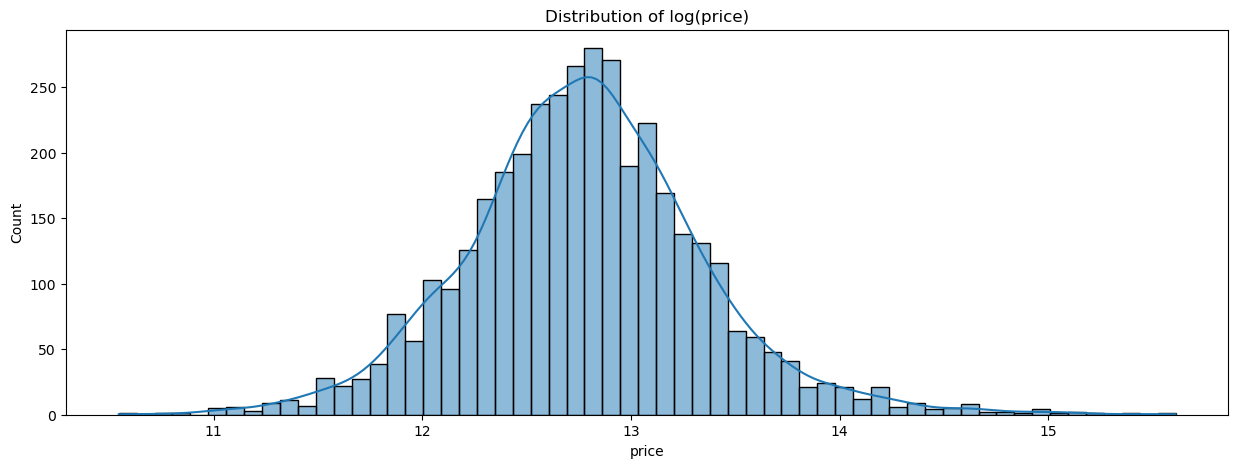

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='price', kde=True)
plt.title('Distribution of log(price)')
plt.show()

#### We can notice that the following:
- Taking log of the price changed its distribution to normal distribution

In [ ]:
# df['number_of_floors'] = np.log(df['number_of_floors'])
# df['completion_year'] = np.log(df['completion_year']) 
# df['bedroom'] = np.log(df['bedroom'])
# df['bathroom'] = np.log(df['bathroom']) 
# df['total_units'] = np.log(df['total_units'])
# df['parking_lot'] = np.log(df['parking_lot']) 
# df['ren_number'] = np.log(df['ren_number']) 

## `Preprocessing`

### `Split Data into train and validation datasets`

In [ ]:
#df= df.rename(str,axis="columns") 

In [ ]:


## Features and target
X = df.drop(columns=['price'], axis=1)
y = df['price']

## to full train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=50)

print('X_train shape', X_train.shape)
print('X_valid shape', X_valid.shape)
print('y_train shape', y_train.shape)
print('y_valid shape', y_valid.shape)

X_train shape (3032, 43)
X_valid shape (758, 43)
y_train shape (3032,)
y_valid shape (758,)


#### `Data Preprocessing`

In [ ]:
## Slice cols
int_cols = X_train.select_dtypes(include=['Int64']).columns.tolist()
float_cols = X_train.select_dtypes(include=['float64']).columns.tolist()
bool_cols = X_train.select_dtypes(include=['bool']).columns.tolist()

#small_categ_cols = ['tenure_type', 'property_type', 'floor_range', 'land_title', 'firm_type', 'ren_type', 'state']
small_categ_cols = ['tenure_type', 'property_type', 'floor_range', 'land_title', 'ren_type', 'city', 'state']

categ_cols = X_train.select_dtypes(include=['object']).columns.tolist()
other_categ_cols = list(set(categ_cols) - set(small_categ_cols)) 

print(int_cols) 
print(float_cols)
print(bool_cols)
print(small_categ_cols)
print(other_categ_cols)

['bedroom', 'bathroom', 'completion_year', 'number_of_floors', 'total_units', 'parking_lot', 'ren_number']
['property_size']
['nearby_school', 'nearby_mall', 'bus_stop', 'mall', 'park', 'school', 'hospital', 'highway', 'nearby_railway_station', 'railway_station', 'Parking', 'Security', 'Swimming Pool', 'Playground', 'Barbeque area', 'Jogging Track', 'Minimart', 'Lift', 'Gymnasium', 'Multipurpose hall', 'Sauna', 'Tennis Court', 'Club house', 'Squash Court']
['tenure_type', 'property_type', 'floor_range', 'land_title', 'ren_type', 'city', 'state']
['developer', 'firm_type', 'building_name', 'firm_number']


In [ ]:
## Pipeline 

## Int --> Impute using mode, Standardization
## float --> Impute using median, Standardization
## bool --> Impute using mode, Ordinal
## Categorical --> Impute using mode, Ordinal


In [ ]:
df.describe(include='object')

,building_name,developer,tenure_type,property_type,floor_range,land_title,firm_type,firm_number,ren_type,state,city
count,3705,2155,3790,3790,2775,3790,3094,3094,2805,3671,2289
unique,1937,580,2,8,3,3,7,335,6,17,47
top,All Seasons Park,Ideal Property Group,Freehold,Condominium,Medium,Non Bumi Lot,E,11584,REN,Selangor,Johor Bahru
freq,25,67,2298,1620,1334,3173,2822,445,2574,1234,231


In [ ]:
X_train.shape[1]

43

In [ ]:
## Int
int_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(int_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
               # ('scaler', MinMaxScaler())
            ])

## Float
float_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(float_cols)),
                ('imputer', SimpleImputer(strategy='median')),
               # ('scaler', MinMaxScaler())
            ])

## Bool
bool_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(bool_cols)),
               # ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder())
                #,
                #('scaler', MinMaxScaler())
            ])

## Categorical
small_categ_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(small_categ_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder( sparse_output=False, handle_unknown='ignore')),
                #('scaler', MinMaxScaler())
            ])

other_categ_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(other_categ_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)),
                #('encoder', BinaryEncoder(drop_invariant=True))
                #,                
                #('scaler', MinMaxScaler())
            ])

## Combine all
all_pipeline = FeatureUnion(transformer_list=[
                        ('int', int_pipline),
                        ('float', float_pipline),
                        ('bool', bool_pipline),
                        ('small_categ', small_categ_pipline),
                        ('other_categ', other_categ_pipline)
                    ])

all_pipeline = Pipeline(steps=[('pipeline', all_pipeline), 
                               ('FeatureSelection', SelectKBest(mutual_info_regression, k= int(0.9 * X_train.shape[1]))),
                               ('Scaler', RobustScaler())])
 

## apply
X_train_final  = all_pipeline.fit_transform(X_train, y_train)
X_valid_final = all_pipeline.transform(X_valid)


 

#### `Feature Selection`

In [ ]:
# x_dummies = pd.get_dummies(X, drop_first= True, )
# x_dummies.shape

In [ ]:
# X_train_final.shape

In [ ]:
# from sklearn.feature_selection import SelectFromModel
# #FeatureSelection = GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=80) 
# FeatureSelection = SelectFromModel(estimator=RandomForestRegressor(n_estimators=150, max_depth=8, random_state=45), max_features=None)
# X_train_final = FeatureSelection.fit_transform(X_train_final, y_train)
# X_valid_final = FeatureSelection.transform(X_valid_final)
# X_train_final.shape

In [ ]:
# from sklearn.feature_selection import chi2, f_classif, GenericUnivariateSelect, SelectKBest, mutual_info_regression
# #FeatureSelection = GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=80) 
# FeatureSelection = SelectKBest(mutual_info_regression, k= 80)
# X_train_final = FeatureSelection.fit_transform(X_train_final, y_train)
# X_valid_final = FeatureSelection.transform(X_valid_final)
# X_train_final.shape

In [ ]:
# FeatureSelection.get_feature_names_out()

In [ ]:

# from sklearn.feature_selection import SelectKBest, mutual_info_regression
# fs = SelectKBest(mutual_info_regression, k= 'all')
# fs.fit(X_train_final, y_train)
# X_train_final = fs.transform(X_train_final)
# X_valid_final = fs.transform(X_valid_final)


# # Get the indices sorted by most important to least important
# plt.figure(figsize=[15, 8])
# indices = np.argsort(fs.scores_)[::-1]

# # To get your top 10 feature names
# features = []
# for i in range(6):
#     features.append(fs.feature_names_in_[indices[i]])

# # Now plot
# sns.barplot(x = fs.scores_[indices[range(6)]], y = features)

In [ ]:
## Check shapes

print('X_train_final.shape \t', X_train_final.shape)
print('y_train_encoded.shape \t', y_train.shape)
print('**'*20)
print('X_valid_final.shape \t', X_valid_final.shape)
print('y_valid_encoded.shape \t', y_valid.shape)  ## fine

X_train_final.shape 	 (3032, 36)
y_train_encoded.shape 	 (3032,)
****************************************
X_valid_final.shape 	 (758, 36)
y_valid_encoded.shape 	 (758,)


## `Building Models`

`Let's consider evaluation metric f1_score `

#### 1. Linear Regression

In [ ]:
## Model Training
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_lin = lin_reg.predict(X_train_final)
y_pred_valid_lin = lin_reg.predict(X_valid_final)

## Evaluate
score_train_lin = r2_score(y_train, y_pred_train_lin)
score_valid_lin = r2_score(y_valid, y_pred_valid_lin)

print(f'R2 Score for Training Dataset using LinearRegression {score_train_lin * 100 :.3f}')
print(f'R2 Score for Valid Dataset using LinearRegression {score_valid_lin * 100 :.3f}')

R2 Score for Training Dataset using LinearRegression 69.065
R2 Score for Valid Dataset using LinearRegression 63.432


#### 2. Polynomail Features

In [ ]:
# Initialize Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=True)

# Polynomial fitting and transforming
X_train_final2 = poly.fit_transform(X_train_final)
X_valid_final2 = poly.transform(X_valid_final)


## Model Training
lin_poly_reg = LinearRegression()
lin_poly_reg.fit(X_train_final2, y_train)

## Predict and evaluate 
y_pred_train_lin_poly = lin_poly_reg.predict(X_train_final2)
y_pred_valid_lin_poly = lin_poly_reg.predict(X_valid_final2)

## Evaluate
score_train_lin_poly = r2_score(y_train, y_pred_train_lin_poly)
score_valid_lin_poly = r2_score(y_valid, y_pred_valid_lin_poly)

print(f'R2 Score for Training Dataset using LinearRegression with PolynomialFeatures {score_train_lin_poly * 100 :.3f}')
print(f'R2 Score for Valid Dataset using LinearRegression with PolynomialFeatures {score_valid_lin_poly * 100 :.3f}')

R2 Score for Training Dataset using LinearRegression with PolynomialFeatures 82.041
R2 Score for Valid Dataset using LinearRegression with PolynomialFeatures 58.121


#### 3. Random Forest

In [ ]:
## Model Training
forst_reg = RandomForestRegressor(n_estimators=150, max_depth=8, random_state=45)
forst_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_reg.predict(X_train_final)
y_pred_valid_forest = forst_reg.predict(X_valid_final)

## Evaluate
score_train_forest = r2_score(y_train, y_pred_train_forest)
score_valid_forest = r2_score(y_valid, y_pred_valid_forest)

print(f'R2 Score for Training Dataset using RF {score_train_forest * 100 :.3f}')
print(f'R2 Score for Valid Dataset using RF {score_valid_forest * 100 :.3f}')

R2 Score for Training Dataset using RF 86.611
R2 Score for Valid Dataset using RF 70.318


#### 4. KNN

In [ ]:
## Model Training
knn_reg = KNeighborsRegressor(n_neighbors=5, p=1, n_jobs=-1)
knn_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_knn = knn_reg.predict(X_train_final)
y_pred_valid_knn = knn_reg.predict(X_valid_final)

## Evaluate
score_train_knn = r2_score(y_train, y_pred_train_knn)
score_valid_knn = r2_score(y_valid, y_pred_valid_knn)

print(f'R2 Score for Training Dataset using knn {score_train_knn * 100 :.3f}')
print(f'R2 Score for Valid Dataset using knn {score_valid_knn * 100 :.3f}')

R2 Score for Training Dataset using knn 80.707
R2 Score for Valid Dataset using knn 62.644


#### 5. SGD with Early Stopping

In [ ]:
## Model Training
SGD_reg = SGDRegressor(penalty=None, learning_rate='constant', eta0=0.001, early_stopping=True, 
                       n_iter_no_change=100, validation_fraction=0.1, max_iter=5000)
SGD_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_SGD = SGD_reg.predict(X_train_final)
y_pred_valid_SGD = SGD_reg.predict(X_valid_final)

## Evaluate
score_train_SGD = r2_score(y_train, y_pred_train_SGD)
score_valid_SGD = r2_score(y_valid, y_pred_valid_SGD)

print(f'R2 Score for Training Dataset using SGDRegressor {score_train_SGD * 100 :.3f}')
print(f'R2 Score for Valid Dataset using SGDRegressor {score_valid_SGD * 100 :.3f}')

R2 Score for Training Dataset using SGDRegressor 68.782
R2 Score for Valid Dataset using SGDRegressor 63.502


#### 6. Ensemble Learning: Voting

In [ ]:
## Voting for (LinearRegression, RandomForest, KNeighbors, SGDRegressor) 
voting_reg = VotingRegressor(estimators=[
                                    ('lin_reg', lin_reg),
                                    ('forst_reg', forst_reg),
                                    ('knn_reg ', knn_reg ),
                                    ('SGD_reg', SGD_reg)
                                        ])


voting_reg.fit(X_train_final, y_train) 

## Predict and evaluate 
y_pred_train_voting = voting_reg.predict(X_train_final)
y_pred_valid_voting = voting_reg.predict(X_valid_final)

## Evaluate
score_train_voting = r2_score(y_train, y_pred_train_voting)
score_valid_voting = r2_score(y_valid, y_pred_valid_voting)

print(f'R2 Score for Training Dataset using voting {score_train_voting * 100 :.3f}')
print(f'R2 Score for Valid Dataset using voting {score_valid_voting * 100 :.3f}')

R2 Score for Training Dataset using voting 80.447
R2 Score for Valid Dataset using voting 69.755


#### 7. Ensemble Learning: Bagging -> RandomForest

In [ ]:
## Model Training
forst_reg = RandomForestRegressor(n_estimators=150, max_depth=7, max_features=0.8, random_state=45,
                                    max_samples=0.8, bootstrap=True, oob_score=True)
forst_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_reg.predict(X_train_final)
y_pred_valid_forest = forst_reg.predict(X_valid_final)

## Evaluate
score_train_forest = r2_score(y_train, y_pred_train_forest)
score_valid_forest = r2_score(y_valid, y_pred_valid_forest)

print(f'R2 Score for Training Dataset using Bagging - RF {score_train_forest * 100 :.3f}')
print(f'R2 Score for Valid Dataset using Bagging - RF {score_valid_forest * 100 :.3f}')

R2 Score for Training Dataset using Bagging - RF 83.117
R2 Score for Valid Dataset using Bagging - RF 70.850


#### 8. Ensemble Learning: Boosting -> AdaBoost

In [ ]:
## Model Training
adaboost_reg = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=7, 
                                                                        max_features=0.8, random_state=48),
                                    n_estimators=150, learning_rate=1)
adaboost_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_adaboost = adaboost_reg.predict(X_train_final)
y_pred_valid_adaboost = adaboost_reg.predict(X_valid_final)

## Evaluate
score_train_adaboost = r2_score(y_train, y_pred_train_adaboost)
score_valid_adaboost = r2_score(y_valid, y_pred_valid_adaboost)

print(f'R2 Score for Training Dataset using AdaBoostRegressor {score_train_adaboost * 100 :.3f}')
print(f'R2 Score for Valid Dataset using AdaBoostRegressor {score_valid_adaboost * 100 :.3f}')

R2 Score for Training Dataset using AdaBoostRegressor 88.876
R2 Score for Valid Dataset using AdaBoostRegressor 71.581


#### 9. Ensemble Learning: Boosting -> GradientBoosting

In [ ]:
## Model Training
gradient_reg = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.1)
gradient_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_gradient = gradient_reg.predict(X_train_final)
y_pred_valid_gradient = gradient_reg.predict(X_valid_final)

## Evaluate
score_train_gradient = r2_score(y_train, y_pred_train_gradient)
score_valid_gradient = r2_score(y_valid, y_pred_valid_gradient)

print(f'R2 Score for Training Dataset using GradientBoosting {score_train_gradient * 100 :.3f}')
print(f'R2 Score for Valid Dataset using GradientBoosting {score_valid_gradient * 100 :.3f}')

R2 Score for Training Dataset using GradientBoosting 92.808
R2 Score for Valid Dataset using GradientBoosting 72.020


#### 10. XGBoost

In [ ]:
## Model Training
XGB_reg = XGBRegressor(n_estimators=150, max_depth=5, 
                        colsample_bytree=0.8, subsample=0.9, reg_lambda=100, learning_rate=0.2)
XGB_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_XGB = XGB_reg.predict(X_train_final)
y_pred_valid_XGB = XGB_reg.predict(X_valid_final)

## Evaluate
score_train_XGB = r2_score(y_train, y_pred_train_XGB)
score_valid_XGB = r2_score(y_valid, y_pred_valid_XGB)

print(f'R2 Score for Training Dataset using XGBRegressor {score_train_XGB * 100 :.3f}')
print(f'R2 Score for Valid Dataset using XGBRegressor {score_valid_XGB * 100 :.3f}')

R2 Score for Training Dataset using XGBRegressor 89.253
R2 Score for Valid Dataset using XGBRegressor 72.715


#### 11. Cross Validation

In [ ]:
y_pred_forest = cross_val_predict(estimator=forst_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
print(f'f1_score for Cross_validation with random forest = {r2_score(y_train, y_pred_forest)}')



f1_score for Cross_validation with random forest = 0.7528706058865533


In [ ]:
## Scores
scores_forest = cross_val_score(estimator=forst_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='r2')
scores_forest.mean()  ## average of f1 score using RF cv=5

0.7583878352691928

In [ ]:


result = cross_validate(estimator=XGB_reg, X=X_train_final, y=y_train, scoring= 'r2', cv= 5, return_train_score= True, n_jobs= -1)
result

{'fit_time': array([2.88827729, 2.87032628, 2.84439588, 2.80151153, 1.31997156]),
 'score_time': array([0.0089767 , 0.00698113, 0.00797796, 0.00598478, 0.00495744]),
 'test_score': array([0.81458333, 0.82584635, 0.82275683, 0.80844831, 0.77655816]),
 'train_score': array([0.9125927 , 0.91346065, 0.91002166, 0.9154639 , 0.91723766])}

## `Performance Tuning`

#### 1. GridSearchCV

In [ ]:
params = {
    'learning_rate': [0.4],
    'max_depth': [4, 5],
    'n_estimators': [250,300],
    'colsample_bytree':[ 0.6],
    'subsample': [0.4, 0.5],
    'reg_lambda': [150, 200] 
    }

from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

grid_search = GridSearchCV(param_grid= params, estimator= XGB_reg, cv = 5, scoring=['r2', 'neg_mean_squared_error'], 
                           refit='r2', return_train_score= True, n_jobs= -1)
grid_search.fit(X_train_final, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.2, max...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=150,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6], 'learning_rate': [0.4],
                         'max_depth': [4, 5], 'n_estimators': [250, 300],
                         'reg_lambda': [150, 200], 'subsample': [0.4, 0.5]},
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'])

In [ ]:
grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.4,
 'max_depth': 5,
 'n_estimators': 300,
 'reg_lambda': 200,
 'subsample': 0.4}

In [ ]:
mean_train_r2 = grid_search.cv_results_['mean_train_r2'].mean()
mean_test_r2 = grid_search.cv_results_['mean_test_r2'].mean()

print(f'R2 Score for Training Dataset using GridSearchCV over XGBRegressor {mean_train_r2 * 100 :.3f}')
print(f'R2 Score for Test Dataset using GridSearchCV over XGBRegressor {mean_test_r2 * 100 :.3f}')

mean_train_neg_mean_squared_error = grid_search.cv_results_['mean_train_neg_mean_squared_error'].mean()
mean_test_neg_mean_squared_error = grid_search.cv_results_['mean_test_neg_mean_squared_error'].mean()

print(f'MSE Score for Training Dataset using GridSearchCV over XGBRegressor {mean_train_neg_mean_squared_error * -1 :.3f}')
print(f'MSE Score for Test Dataset using GridSearchCV over XGBRegressor {mean_test_neg_mean_squared_error * -1 :.3f}')

R2 Score for Training Dataset using GridSearchCV over XGBRegressor 93.014
R2 Score for Test Dataset using GridSearchCV over XGBRegressor 79.872
MSE Score for Training Dataset using GridSearchCV over XGBRegressor 0.023
MSE Score for Test Dataset using GridSearchCV over XGBRegressor 0.065


In [ ]:
## Predict and evaluate  
y_pred_valid_Grid_Search_XGB = grid_search.best_estimator_.predict(X_valid_final)

## Evaluate 
r2_score_valid_XGB = r2_score(y_valid, y_pred_valid_Grid_Search_XGB)
mse_score_valid_XGB = mean_squared_error(y_valid, y_pred_valid_Grid_Search_XGB)

print(f'R2 Score for Valid Dataset using GridSearchCV over XGBRegressor {r2_score_valid_XGB * 100 :.3f}')
print(f'MSE Score for Valid Dataset using GridSearchCV over XGBRegressor {mse_score_valid_XGB :.3f}')

R2 Score for Valid Dataset using GridSearchCV over XGBRegressor 74.718
MSE Score for Valid Dataset using GridSearchCV over XGBRegressor 0.080
